## Goal
--
This notebook explores multiple avenues of calculating the model's uncertainty estimates for each new image.

Specifically, we write code to explore **Uncertainty-based Querying**, in which the model selects instances for labeling that exhibit the highest uncertainty of the class probabilities associated with each instance. We look at the following methods:

**Least Margin**: Uncertainty is defined as the margin between the predicted probabilities of the top two candidate classes. Instances with lower margins are considered to be more uncertain.
        $$U(x) = 1 - (\max_{y \in Y} \hat{P}_{\theta}(y|x) - \max_{y \neq y_{max}} \hat{P}_{\theta}(y|x))$$


**Least Confidence**: Uncertainty is measured by the maximal class probability value, with lower maximal class probabilities denoting more uncertainty.
        $$U(x) = 1 - \max_{y \in Y} \hat{P}_{\theta}(y|x)$$
      
**Entropy**: Uncertainty is measured as entropy (H(x)), with higher entropy denoting more uncertainty. 
        $$U(x) = -\sum_{y \in Y} \hat{P}_{\theta}(y |x)\log(\hat{P}_{\theta}(y|x))$$


These methods have the benefit of both priming the next set of images to retrain the model but also allowing for a easy thresholding below which, we wouldn't need to validate the model's prediction at all.


---
*This next section is not the focus of this notebook:*

In the event of purely focusing on model retraining, we could also explore **Diversity-Based Querying**, in which the model selects instances for labeling that represent the existing data distribution.
An example of diversity-based sampling would be **Representative Sampling with K-medoids**. In this case, we assume prior knowledge of the number of classes, $C$, and identify $C$ clusters using the K-medoids algorithm. Then, we sample an equal number of data points from each cluster. This can potentially be modified by selecting a set proportion per cluster to address imbalanced datasets.

Another promising approach is **Log-probs Soft K-means Sampling (LSS)**. This is a combined querying strategy introduced by Abdali et al. in 2023 \[1\].  LSS integrates the log-probabilities of instances with soft K-means sampling. It leverages the clusering of the model predictions (prior to last linear layer) to generate a probability of being within each of the $C$ clusters. Then it weigh the importances of instances while also incorporating the diversity aspect through soft K-means sampling. Specifically, this uses soft K-means to select 1 representative sample from each class before iteratively selecting the least confident samples within the cluster. Least confidence here is measured by the soft-probability of belonging to the cluster. This combination aims to enhance the effectiveness of active learning by considering both uncertainty and diversity aspects simultaneously. We once again will need to assume prior knowledge of the number of classes and shuffle the order of clusters when iteratively selecting the least confident samples.

**Citations**:
1. Abdali, Vincent Gripon, Lucas Drumetz, and Bartosz
Boguslawski. Active learning for efficient few-shot classification. In *ICASSP 2023 - 2023 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)*, pages
1–5, 2023

## 0. Set-up
---
To begin, we'll need to import all necessary modules. This should come installed with the virtual environment provided by [`environment.yml`](../environment.yml).

If not, please install the modules with the following commands:

```bash
pip install <module_name>
```

or 

```bash
conda install <module_name>
```

In [3]:
# Base models
import sys
from importlib import reload
from tqdm.auto import trange, tqdm

# Plotting & Array Manipulation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Science Modules
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# import data_utils from the PIVOT app
sys.path.append('../PIVOT/')
import utils.data_utils as du
reload(du)

<module 'utils.data_utils' from 'C:\\Users\\ysman\\Desktop\\Capstone\\PIVOT\\notebooks\\../PIVOT\\utils\\data_utils.py'>

## 1. Gather Data & Compute Query Functions
---
Next, let's gather our data of probabilities for each class. This can be found under `./data/inventory_df_with_probs.parquet.gzip`. Note, this dataset was generated using the code from [`Parallelized_Image_Loading.ipynb`](../notebooks/Parallelized_Image_Loading.ipynb)

Essentially, dataset contains the following attributes:
* `image_path`: the location of the file on Ali Chase's VM
* `pred_label`: an integer denoting which class the the model predicts the image to be.
* `pred_class`: the corresponding text description of each class. (None/NaN denote "Unidentifiable")
* `0`: the probability of the image belonging to class 0
* `1`: the probability of the image belonging to class 1
$$\dots$$

* `9`: the probability of the image belonging to class 9

For our analysis, we'll only use the columns with the class probabilities.

In [4]:
df = pd.read_parquet("./data/inventory_df_with_probs.parquet.gzip")

df.head()

,Index,image_path,pred_label,pred_class,index,0,1,2,3,4,5,6,7,8,9
0,0,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,0,0.003190,2.078881e-11,8.588634e-05,0.000173,8.921839e-08,0.003271,8.093556e-06,0.957533,0.035501,0.000237
1,1,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,1,0.007551,5.126985e-07,3.592776e-04,0.002601,2.534480e-06,0.204228,1.017940e-03,0.718851,0.061205,0.004183
2,2,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,9,None,2,0.000135,1.200640e-11,1.257837e-05,0.000220,2.652156e-05,0.000103,1.847491e-07,0.390917,0.000375,0.608209
3,3,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,3,0.001123,1.054870e-14,4.769512e-05,0.000167,1.587807e-10,0.013132,1.304258e-05,0.984470,0.000259,0.000788
4,4,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,4,0.000100,7.816149e-09,8.546382e-08,0.008106,8.124642e-09,0.343707,2.029714e-05,0.645359,0.000388,0.002319


### Define the Functions

Each score is defined as its own function and called under a wrapper function `get_score()` for easy iteration.

In [15]:
def least_confident_score(x):
    return 1 - np.max(x)

def least_margin_score(x):
    sort_x = np.sort(x)
    return 1 - (sort_x[-1] - sort_x[-2])

def entropy_score(x):
    return -x.T @ np.nan_to_num(np.log(x))

def get_score(x, f):
    try:
        s = f(x)
    except:
        print(f"Error computing {f.__name__}")
        s = -1
    return s

### Compute Scores
Now, we loop through all the rows of the dataframe to compute the scores and store them as three new colums: `entropy_score`, `least_confidence_score`, and `least_margin_score`.

In [125]:
%%time
for f in tqdm([
    least_confident_score, 
    least_margin_score, 
    entropy_score
]):
    df[str(f.__name__)] = df[list(np.arange(10).astype(int).astype(str))].apply(lambda x: get_score(x,f), axis=1)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 29.6 s
Wall time: 30.8 s


In [137]:
df.head()

,Index,image_path,pred_label,pred_class,index,0,1,2,3,4,5,6,7,8,9,entropy_score,least_confident_score,least_margin_score
0,0,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,0,0.003190,2.078881e-11,8.588634e-05,0.000173,8.921839e-08,0.003271,8.093556e-06,0.957533,0.035501,0.000237,0.201498,0.042467,0.077968
1,1,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,1,0.007551,5.126985e-07,3.592776e-04,0.002601,2.534480e-06,0.204228,1.017940e-03,0.718851,0.061205,0.004183,0.817881,0.281149,0.485377
2,2,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,9,NaN,2,0.000135,1.200640e-11,1.257837e-05,0.000220,2.652156e-05,0.000103,1.847491e-07,0.390917,0.000375,0.608209,0.676992,0.391791,0.782708
3,3,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,3,0.001123,1.054870e-14,4.769512e-05,0.000167,1.587807e-10,0.013132,1.304258e-05,0.984470,0.000259,0.000788,0.089775,0.015530,0.028662
4,4,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,4,0.000100,7.816149e-09,8.546382e-08,0.008106,8.124642e-09,0.343707,2.029714e-05,0.645359,0.000388,0.002319,0.706994,0.354641,0.698348


In [157]:
df[['pred_label', 'pred_class']].drop_duplicates().sort_values(by='pred_label').reset_index(drop=True)

,pred_label,pred_class
0,0,Chloro
1,1,Cilliate
2,2,Crypto
3,3,Diatom
4,4,Dictyo
5,5,Dinoflagellate
6,6,Eugleno
7,7,Other
8,8,Prymnesio
9,9,NaN


Note that all 9s are NaN, denoting the "Unidentifiable" class. "Other" represents other known phytoplankton while "Unidentiable" could be bad images or detritus (non-living matter).

### Store Model Output 

To avoid recomputation, we store the output to `./data/inventory_df_with_probs.parquet.gzip`.

In [146]:
df_no_probs = df.drop(columns=list(np.arange(10).astype(int).astype(str)))
df_no_probs.to_parquet("./data/inventory_df_with_scores.parquet.gzip", index=False, compression='gzip')

## 2. Check Rank-Order

Now, we investigate the distributions of each score.

In [8]:
df = pd.read_parquet("./data/inventory_df_with_scores.parquet.gzip")

In [10]:
df[['entropy_score', 'least_confident_score', 'least_margin_score']]

,entropy_score,least_confident_score,least_margin_score
0,0.201498,0.042467,0.077968
1,0.817881,0.281149,0.485377
2,0.676992,0.391791,0.782708
3,0.089775,0.015530,0.028662
4,0.706994,0.354641,0.698348
...,...,...,...
1055995,0.234404,0.057854,0.112909
1055996,1.129720,0.399378,0.606505
1055997,1.289111,0.385930,0.545256
1055998,0.526977,0.174938,0.332709


### Spearman Rank Correlations

We see that all three methods are rather highly correlated to one another. However, their distributions might differ...

In [163]:
columns_to_compare = ["entropy_score", "least_confident_score", "least_margin_score"]

# Calculate Spearman rank correlation coefficients and p-values
cor_entropy_vs_confident, p_value_entropy_vs_confident = spearmanr(df["entropy_score"], df["least_confident_score"])
cor_entropy_vs_margin, p_value_entropy_vs_margin = spearmanr(df["entropy_score"], df["least_margin_score"])
cor_confident_vs_margin, p_value_confident_vs_margin = spearmanr(df["least_confident_score"], df["least_margin_score"])

# Display results
print(f"Spearman Rank Correlation Coefficients:")
print(f"entropy_score vs least_confident_score: {cor_entropy_vs_confident}, p-value: {p_value_entropy_vs_confident}")
print(f"entropy_score vs least_margin_score: {cor_entropy_vs_margin}, p-value: {p_value_entropy_vs_margin}")
print(f"least_confident_score vs least_margin_score: {cor_confident_vs_margin}, p-value: {p_value_confident_vs_margin}")


Spearman Rank Correlation Coefficients:
entropy_score vs least_confident_score: 0.9964544145451807, p-value: 0.0
entropy_score vs least_margin_score: 0.9927704277719999, p-value: 0.0
least_confident_score vs least_margin_score: 0.9990185759491628, p-value: 0.0


### Plotting Distributions

When we plot the distributions, we see that the frequency of `least_margin_score` plateaus pretty early on into the ranking. Meanwhile, `least_confidence` also plateaus for a while with a sudden drop later on. `entropy_score`, on the otherhand plateaus for a bit before steadily decreasing in frequency.

In our use case, we would want few samples with high scores (denoting most uncertain) but also for the score to scale evenly before meeting some threshold below which the model predictions are known to be correct.

`entropy_score` most evenly scales with the score and is therefore our first choice for subsequent exploration.

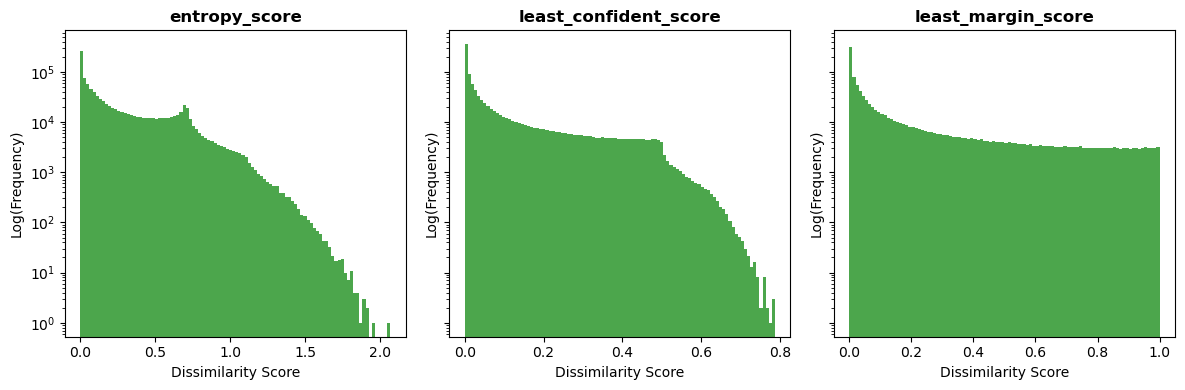

In [5]:
columns_to_compare = ["entropy_score", "least_confident_score", "least_margin_score"]

# Set up subplots for each column
fig, axes = plt.subplots(ncols=len(columns_to_compare), nrows=1, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.5)

for i, col in enumerate(columns_to_compare):
    # Plot log-histogram of values
    axes[i].hist(df[col], bins=100, color='green', alpha=0.7)
    axes[i].set_title(f'{col}', weight='bold')
    axes[i].set_xlabel('Dissimilarity Score')
    axes[i].set_ylabel('Log(Frequency)')
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()


In [200]:
df_ranks.astype(int).sort_values(by = 'entropy_score')

,entropy_score,least_confident_score,least_margin_score
3163,1,102,2
7474,2,183,4
8219,3,188,5
8343,4,191,6
9673,5,203,9
...,...,...,...
670965,1055996,1055914,1027005
961125,1055997,1055970,1045129
722824,1055998,1055986,1049603
256206,1055999,1055957,1034886


CPU times: total: 953 ms
Wall time: 939 ms


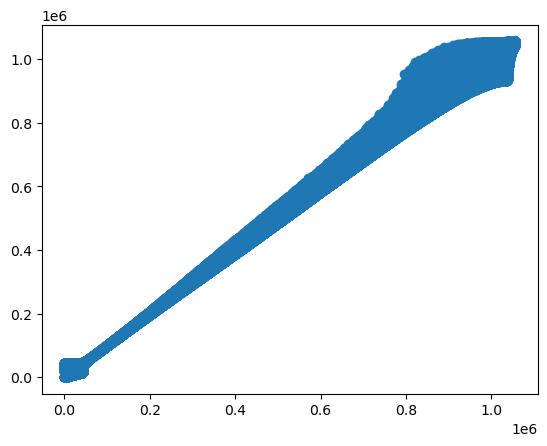

In [13]:
%%time
df_ranks = df[columns_to_compare].rank(method='first').astype(int)

plt.scatter(df_ranks.astype(int).sort_values(by = 'least_confident_score')['least_confident_score'],
         df_ranks.astype(int).sort_values(by = 'least_confident_score')['entropy_score']
        )

We also plot the ranks of each methods against each other. From this we see that the rankings between Least Margin and Least Confidence are far more similar (closer to a straight line) compared to that of the Entropy scores (more oblong plots).

In [ ]:
%%time
df_ranks = df[columns_to_compare].rank(method='first').astype(int)

plt.plot(df_ranks.astype(int).sort_values(by = 'least_confident_score')['least_confident_score'],
         df_ranks.astype(int).sort_values(by = 'least_confident_score')['entropy_score']
        )

  0%|          | 0/3 [00:00<?, ?it/s]

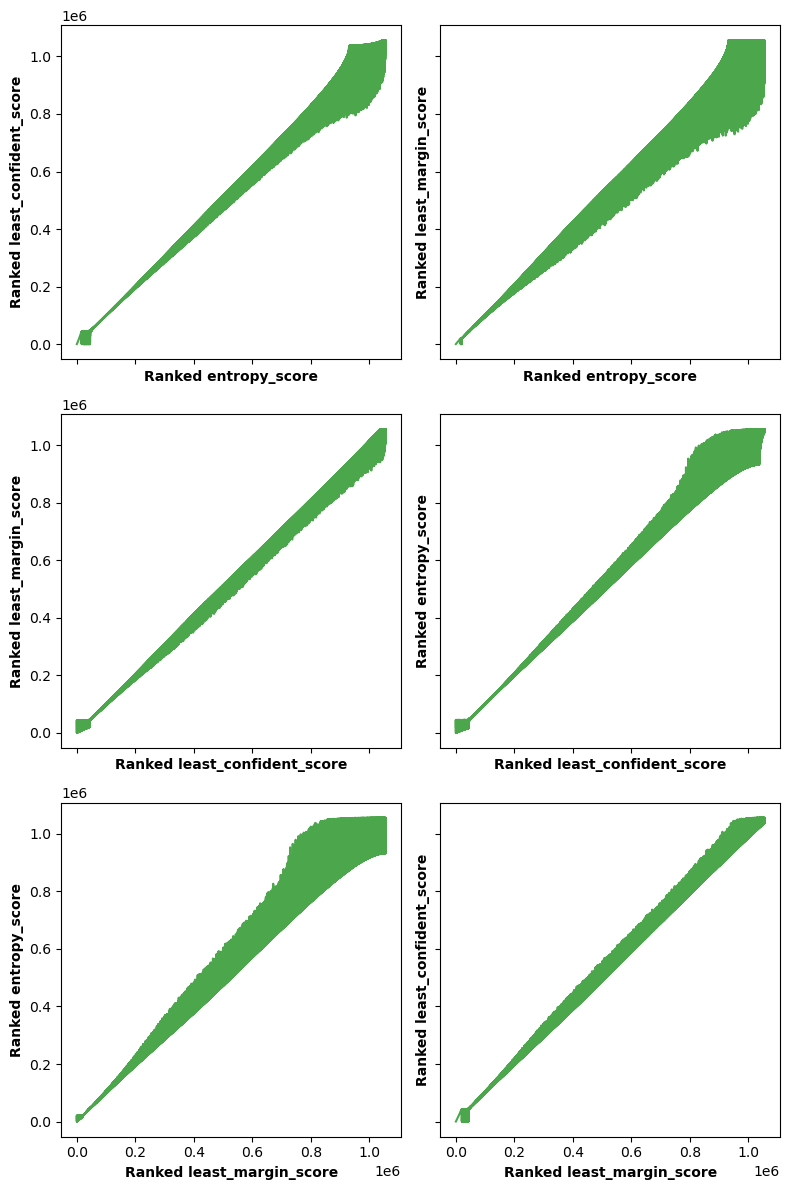

In [14]:
columns_to_compare = ["entropy_score", "least_confident_score", "least_margin_score"]

# Convert numerical columns to ranks
df_ranks = df[columns_to_compare].rank(method='first').astype(int)

# Set up subplots for each column
fig, axes = plt.subplots(ncols=len(columns_to_compare)-1, 
                         nrows=len(columns_to_compare), 
                         figsize=(8, 12), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.5)

for i, col in enumerate(tqdm(columns_to_compare)):
    # Plot log-histogram of values
    tmp_df = df_ranks.sort_values(by=f'{col}')
    for j in range(1, len(columns_to_compare)):
        col_j = columns_to_compare[(i+j) % len(columns_to_compare)]
        axes[i,j-1].plot(tmp_df[col], tmp_df[col_j], color='green', alpha=0.7)
#         axes[i,j].set_title(f'{col}', weight='bold')
        axes[i,j-1].set_xlabel(f'Ranked {col}', weight='bold')
        axes[i,j-1].set_ylabel(f'Ranked {col_j}', weight='bold')
#     axes[i].set_yscale('log')

plt.tight_layout()
# plt.savefig("rank_comparisons.png", dpi=400)


## 3. Check Validated DataFrame

While, we already computed the scores, now, we check how well each method performs on the "known" data, located at `./PIVOT/data/model-summary-cnn-v1-b3.csv`. Please note that this is the TRAINING data and any conlcusions must be validated on a new set of validation data!

In [13]:
validated_df = pd.read_csv('../PIVOT/data/model-summary-cnn-v1-b3.csv')

### Compute Scores

In [16]:
%%time
for f in tqdm([
    least_confident_score, 
    least_margin_score, 
    entropy_score
]):
    validated_df[str(f.__name__)] = validated_df[list(np.arange(10).astype(int).astype(str))].apply(lambda x: get_score(x,f), axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\ysman\anaconda3\envs\pivot-modAL\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: total: 1min 9s
Wall time: 1min 9s


In [17]:
correct_valid_data = validated_df[validated_df['is_correct'] ==1]
incorrect_valid_data = validated_df[validated_df['is_correct'] == 0]
outside_top_5 = validated_df[validated_df['top_5'] == 0]

### Plot Distributions

In each row we plot the frequency of the Correct classifications (Green), Incorrect classifications (Blue), and classifications for which the true class probability lies outside the top 5 (Red). We see similar distributions across all classification subsets and the score distributions match those of the 1M unvalidated data above.

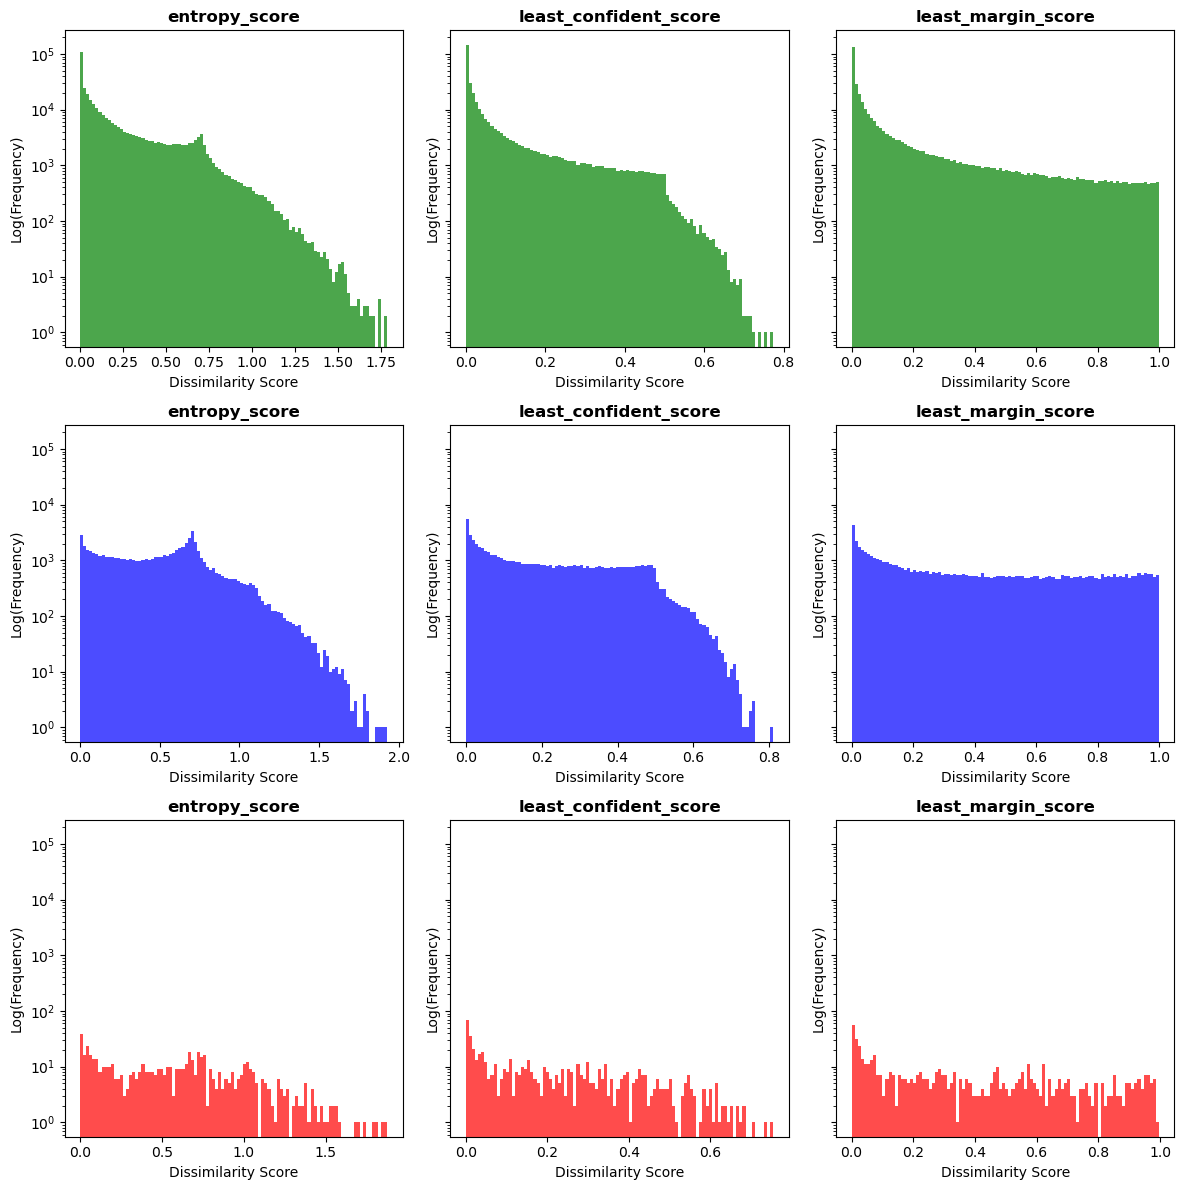

In [7]:
columns_to_compare = ["entropy_score", "least_confident_score", "least_margin_score"]

# Set up subplots for each column
fig, axes = plt.subplots(ncols=len(columns_to_compare), nrows=3, figsize=(12, 12), sharey=True, sharex=False)
fig.subplots_adjust(wspace=0.5)

for i, col in enumerate(columns_to_compare):
    # Plot log-histogram of values
    axes[0,i].hist(correct_valid_data[col], bins=100, color='green', alpha=0.7)
    axes[0,i].set_title(f'{col}', weight='bold')
    axes[0,i].set_xlabel('Dissimilarity Score')
    axes[0,i].set_ylabel('Log(Frequency)')
    axes[0,i].set_yscale('log')

    axes[1,i].hist(incorrect_valid_data[col], bins=100, color='blue', alpha=0.7)
    axes[1,i].set_title(f'{col}', weight='bold')
    axes[1,i].set_xlabel('Dissimilarity Score')
    axes[1,i].set_ylabel('Log(Frequency)')
    axes[1,i].set_yscale('log')
    
    axes[2,i].hist(outside_top_5[col], bins=100, color='red', alpha=0.7)
    axes[2,i].set_title(f'{col}', weight='bold')
    axes[2,i].set_xlabel('Dissimilarity Score')
    axes[2,i].set_ylabel('Log(Frequency)')
    axes[2,i].set_yscale('log')
plt.tight_layout()
plt.show()


### Potential Identification of Optimal Thresholds

Here, we plot the accuracies below a given threshold (Blue) and the accuracies for all images above that same threshold (red).

Entropy has an inflection point for accuracies around 0.85 (Blue) while the other's steadily decrease throughout.

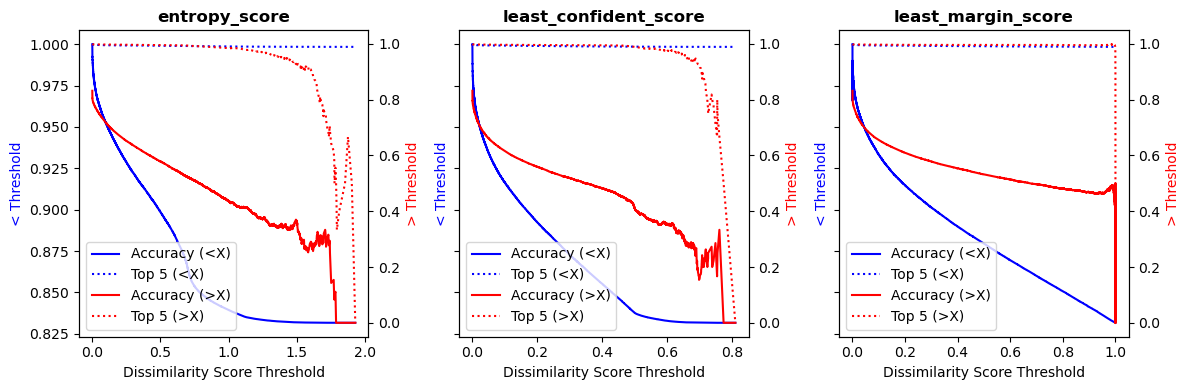

In [20]:
columns_to_compare = ["entropy_score", "least_confident_score", "least_margin_score"]

# Set up subplots for each column
fig, axes = plt.subplots(ncols=len(columns_to_compare), nrows=1, figsize=(12, 4), sharey=True, sharex=False)
fig.subplots_adjust(wspace=0.5)


for i, col in enumerate(columns_to_compare):
    # Plot log-histogram of values
    val_df = validated_df[columns_to_compare + ['is_correct', 'top_5','pred_label', 'true_label']]
    val_df = val_df.sort_values(by=f'{col}', ascending=True)
    
    val_df['score_acc'] = val_df['is_correct'].cumsum()/np.arange(1,len(val_df)+1)
    val_df['score_acc_r'] = (np.sum(val_df['is_correct']) - val_df['is_correct'].cumsum())/np.arange(len(val_df), 0,-1)

    val_df['score_top5'] = val_df['top_5'].cumsum()/np.arange(1,len(val_df)+1)
    val_df['score_top5_r'] = (np.sum(val_df['top_5']) - val_df['top_5'].cumsum())/np.arange(len(val_df), 0,-1)

    ax = axes[i]
    ax.plot(val_df[col], val_df.score_acc, label='Accuracy (<X)', color= 'blue')
    ax.plot(val_df[col], val_df.score_top5, label='Top 5 (<X)', ls= ':', color='blue')

    lines, labels = ax.get_legend_handles_labels()

    ax2 = ax.twinx()
    ax2.plot(val_df[col], val_df.score_acc_r, label='Accuracy (>X)', color='red')
    ax2.plot(val_df[col], val_df.score_top5_r, label='Top 5 (>X)', ls=':', color='red')

    ax.set_ylabel('< Threshold', color='blue')
    ax2.set_ylabel('> Threshold', color='red')
    # Combine legends from both plots
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines + lines2, labels + labels2)


    axes[i].set_title(f'{col}', weight='bold')
    axes[i].set_xlabel('Dissimilarity Score Threshold')
    

plt.tight_layout()
plt.show()


The percent of images that can be auto labeled at a given accuracy threshold are fairly similar for each uncertainty method.

In [33]:
percent_dict ={}
for i, col in enumerate(columns_to_compare):
    # Plot log-histogram of values
    val_df = validated_df[columns_to_compare + ['is_correct', 'top_5','pred_label', 'true_label']]
    val_df = val_df.sort_values(by=f'{col}', ascending=True)
    
    val_df['score_acc'] = val_df['is_correct'].cumsum()/np.arange(1,len(val_df)+1)
    val_df['score_top5'] = val_df['top_5'].cumsum()/np.arange(1,len(val_df)+1)
    
    print(f"Score: {col}")
    for acc in [85, 90, 95, 100]:
        cnt = len(val_df.query(f"score_acc >={acc/100}"))
        print(f"For {acc}% Accuracy: {cnt/len(val_df):.2%} of the data can be auto labeled")
    cnts = []
    for acc in np.linspace(83, 100, 50):
        cnts.append(len(val_df.query(f"score_acc >={acc/100}"))/len(val_df))
    percent_dict[col] = cnts

Score: entropy_score
For 85% Accuracy: 94.77% of the data can be auto labeled
For 90% Accuracy: 78.58% of the data can be auto labeled
For 95% Accuracy: 50.65% of the data can be auto labeled
For 100% Accuracy: 0.32% of the data can be auto labeled
Score: least_confident_score
For 85% Accuracy: 95.17% of the data can be auto labeled
For 90% Accuracy: 78.96% of the data can be auto labeled
For 95% Accuracy: 51.65% of the data can be auto labeled
For 100% Accuracy: 0.06% of the data can be auto labeled
Score: least_margin_score
For 85% Accuracy: 95.05% of the data can be auto labeled
For 90% Accuracy: 79.00% of the data can be auto labeled
For 95% Accuracy: 52.55% of the data can be auto labeled
For 100% Accuracy: 0.01% of the data can be auto labeled


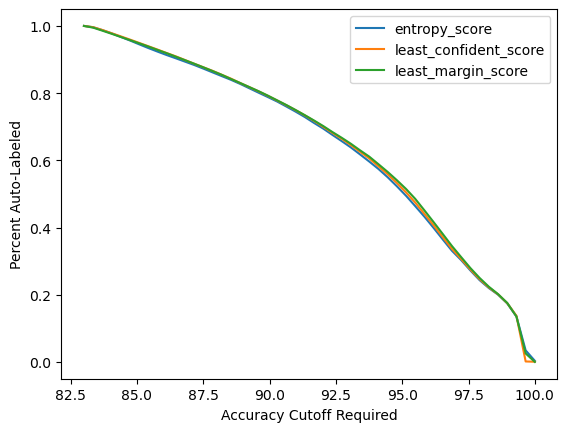

In [38]:
for col in percent_dict:
    plt.plot(np.linspace(83, 100, 50), percent_dict[col], label=col)
plt.xlabel("Accuracy Cutoff Required")
plt.ylabel("Percent Auto-Labeled")
plt.legend()

### Try to predict misclassifications

We attempt to use LogReg to find an optimal decision boundary with the scores such that any image with score below some value, X, can be classified as correctly classified by the model. However, the results are similar across all methods it is clear that THIS ISN'T the right approach for this situation.

entropy_score
Accuracy: 0.8321977087398069
Confusion Matrix:
[[ 2325 14477]
 [ 2294 80849]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.14      0.22     16802
           1       0.85      0.97      0.91     83143

    accuracy                           0.83     99945
   macro avg       0.68      0.56      0.56     99945
weighted avg       0.79      0.83      0.79     99945

-----------


C:\Users\ysman\anaconda3\envs\pivot-modAL\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


least_confident_score
Accuracy: 0.8324378408124469
Confusion Matrix:
[[ 3426 13376]
 [ 3371 79772]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.20      0.29     16802
           1       0.86      0.96      0.91     83143

    accuracy                           0.83     99945
   macro avg       0.68      0.58      0.60     99945
weighted avg       0.80      0.83      0.80     99945

-----------


C:\Users\ysman\anaconda3\envs\pivot-modAL\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


least_margin_score
Accuracy: 0.8314973235279404
Confusion Matrix:
[[ 3499 13303]
 [ 3538 79605]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.21      0.29     16802
           1       0.86      0.96      0.90     83143

    accuracy                           0.83     99945
   macro avg       0.68      0.58      0.60     99945
weighted avg       0.80      0.83      0.80     99945

-----------


C:\Users\ysman\anaconda3\envs\pivot-modAL\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


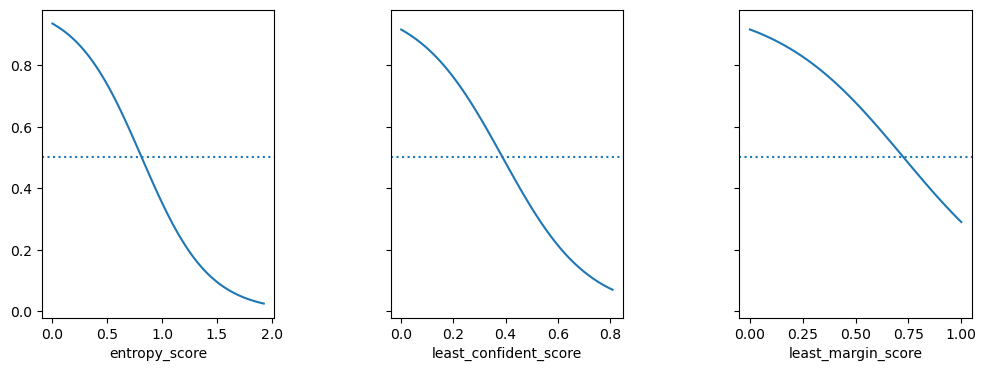

In [21]:
columns_to_compare = ["entropy_score", "least_confident_score", "least_margin_score"]

fig, axes = plt.subplots(ncols=len(columns_to_compare), nrows=1, figsize=(12, 4), sharey=True, sharex=False)
fig.subplots_adjust(wspace=0.5)

for i, col in enumerate(columns_to_compare):
    # Split the data into features (X) and target (y)
    X = validated_df[[f'{col}']]
    y = validated_df['is_correct']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Print the evaluation metrics
    print(f"{col}")
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{classification_rep}')
    scores_range = np.linspace(validated_df[col].min(), validated_df[col].max(), 100).reshape(-1, 1)
    print("-----------")
    # Predict probabilities using the trained model
    probabilities_range = model.predict_proba(scores_range)[:, 1]
    axes[i].plot(scores_range, probabilities_range)
    axes[i].axhline(0.5, ls= ':')
    axes[i].set_xlabel(f"{col}")

In [17]:
validated_df[col].max()

0.9999919500000001